In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import cv2
from tqdm import tqdm
import tensorflow as tf

float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

FLAG_FULL_TEST_MODE = False
FLAS_IMAGE_SIZE = 256

#GPU settings
os.environ["CUDA_VISIBLE_DEVICES"]="0"
np.random.seed(2016)
# set tensorflow don't use total GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

print('Read dataset ------------------------------')

x_train = []
x_valid = []
y_train = []
y_valid = []

df_train = pd.read_csv('input/train.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
print("labels = ", labels)
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

#one hot encording
labels_size = len(labels)
for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('input/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(labels_size)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (FLAS_IMAGE_SIZE, FLAS_IMAGE_SIZE)))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

print(x_train.shape)
print(y_train.shape)

split = x_train.shape[0]*0.8
if(FLAG_FULL_TEST_MODE):
    x_train, x_valid, y_train, y_valid = x_train[:], x_train[split:], y_train[:], y_train[split:]
else:
    x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]


Using TensorFlow backend.
  0%|          | 0/40479 [00:00<?, ?it/s]

Read dataset ------------------------------
('labels = ', ['slash_burn', 'clear', 'blooming', 'primary', 'cloudy', 'conventional_mine', 'water', 'haze', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'blow_down', 'agriculture', 'road', 'selective_logging'])


100%|██████████| 40479/40479 [00:58<00:00, 690.65it/s]


(40479, 256, 256, 3)
(40479, 17)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [4]:
import net_inception as inc_net
from keras.optimizers import SGD
import keras.backend as K

print('start training ------------------------------')    

inc_model = inc_net.build_model(labels_size)
print(len(inc_model.layers))
inc_model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])
          
inc_model.fit(x_train, y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(x_valid, y_valid))


print(len(inc_model.layers))
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in inc_model.layers[:172]:
    layer.trainable = False
for layer in inc_model.layers[172:]:
    layer.trainable = True

for i in range(1,4):
    print "mega-epoch %d/3" % i
    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    inc_model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=["accuracy"])
    inc_model.fit(x_train, y_train,
              batch_size=128,
              epochs=5,
              verbose=1,
              validation_data=(x_valid, y_valid))

start training ------------------------------
314
Train on 32383 samples, validate on 8096 samples
Epoch 1/2
32383/32383 [==============================] - 253s - loss: 0.1680 - acc: 0.9375 - val_loss: 0.1591 - val_acc: 0.9385

In [5]:
import net_resnet50 as res_net
from keras.optimizers import SGD
import keras.backend as K

res_model = res_net.build_model(labels_size)
print(len(res_model.layers))
res_model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])
          
res_model.fit(x_train, y_train,
          batch_size=128,
          epochs= 1,
          verbose=1,
          validation_data=(x_valid, y_valid))


print(len(res_model.layers))
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
#for layer in model.layers[:172]:
#    layer.trainable = False
#for layer in model.layers[172:]:
#    layer.trainable = True

for i in range(1,4):
    print "mega-epoch %d/3" % i
    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    res_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=["accuracy"])
    res_model.fit(x_train, y_train,
              batch_size=128,
              epochs=5,
              verbose=1,
              validation_data=(x_valid, y_valid))

net_resnet50.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("im...)`
  model = Model(input=input, output=predictions)


5
Train on 32383 samples, validate on 8096 samples
Epoch 1/1
32383/32383 [==============================] - 326s - loss: 0.1359 - acc: 0.9494 - val_loss: 1.1256 - val_acc: 0.8439

In [ ]:
#plt.plot(train_losses, label='Training loss')
#plt.plot(val_losses, label='Validation loss')
#plt.legend();

In [6]:
from sklearn.metrics import fbeta_score
from itertools import compress
import matplotlib.pyplot as plt

inc_p_valid = inc_model.predict(x_valid, batch_size=128)
res_p_valid = res_model.predict(x_valid, batch_size=128)
print(y_valid)
print(y_valid[0])
print(inc_p_valid)
print(res_p_valid)
print(inc_p_valid[0])
print(res_p_valid[0])
print(np.array(inc_p_valid) > 0.2)
print(np.array(res_p_valid) > 0.2)
print(fbeta_score(y_valid, np.array(inc_p_valid) > 0.2, beta=2, average='samples'))
print(fbeta_score(y_valid, np.array(res_p_valid) > 0.2, beta=2, average='samples'))

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 1 0 ..., 1 0 0]
 [0 1 0 ..., 1 1 0]
 [0 0 0 ..., 1 0 0]]
[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
[[0.00 0.00 0.00 ..., 0.04 0.00 0.00]
 [0.00 0.00 0.00 ..., 0.03 0.01 0.00]
 [0.00 0.03 0.00 ..., 0.00 0.00 0.00]
 ..., 
 [0.01 0.95 0.00 ..., 0.90 0.17 0.01]
 [0.00 0.64 0.00 ..., 1.00 1.00 0.00]
 [0.03 0.00 0.00 ..., 0.72 0.19 0.01]]
[[0.00 0.00 0.00 ..., 0.08 0.02 0.00]
 [0.00 0.00 0.00 ..., 0.05 0.03 0.00]
 [0.00 0.00 0.01 ..., 0.01 0.01 0.00]
 ..., 
 [0.00 0.81 0.00 ..., 0.56 0.37 0.00]
 [0.00 0.47 0.00 ..., 1.00 1.00 0.00]
 [0.08 0.06 0.02 ..., 0.83 0.15 0.01]]
[0.00 0.00 0.00 0.92 0.23 0.00 0.07 0.05 0.01 0.45 0.00 0.00 0.00 0.00 0.04
 0.00 0.00]
[0.00 0.00 0.00 0.94 0.11 0.00 0.20 0.39 0.01 0.84 0.00 0.01 0.00 0.00 0.08
 0.02 0.00]
[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False  True False ...,  True False False]
 [Fal

In [7]:
print('start output testing result ------------------------------')              
test_img_path = 'input/test-jpg/'
x_test_name = []
x_test = []
for test_img in tqdm(os.listdir(test_img_path)):
    img = cv2.imread(os.path.join(test_img_path,test_img))
    x_test.append(cv2.resize(img, (FLAS_IMAGE_SIZE, FLAS_IMAGE_SIZE)))
    x_test_name.append(test_img)
x_test = np.array(x_test, np.float16) / 255.


start output testing result ------------------------------


100%|██████████| 61191/61191 [01:40<00:00, 611.91it/s]


In [8]:
test_inc_p_valid = inc_model.predict(x_test, batch_size=128)
test_res_p_valid = res_model.predict(x_test, batch_size=128)

(61191, 17)
[0.00 0.97 0.00 1.00 0.00 0.00 0.08 0.00 0.11 0.01 0.00 0.28 0.00 0.00 0.96
 0.97 0.00]
[0.02 0.95 0.00 1.00 0.00 0.00 0.08 0.00 0.53 0.05 0.00 0.22 0.02 0.00 0.98
 0.90 0.00]
[0.01 0.96 0.00 1.00 0.00 0.00 0.08 0.00 0.32 0.03 0.00 0.25 0.01 0.00 0.97
 0.93 0.00]
('img ', 'file_18592.jpg', ' inc predict result', ['clear', 'primary', 'habitation', 'agriculture', 'road'])
('img ', 'file_18592.jpg', ' res predict result', ['clear', 'primary', 'cultivation', 'habitation', 'agriculture', 'road'])
('img ', 'file_18592.jpg', ' cb predict result', ['clear', 'primary', 'cultivation', 'habitation', 'agriculture', 'road'])


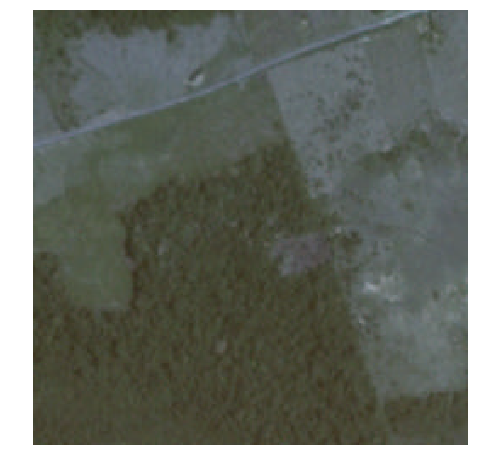

write result to csv ------------------------------
61191
finish! 


In [14]:
print(test_inc_p_valid.shape)
test_cb_p_valid = (test_inc_p_valid + test_res_p_valid)/2
print (test_inc_p_valid[0])
print (test_res_p_valid[0])
print (test_cb_p_valid[0])

inc_predict_result = list(compress(labels, test_inc_p_valid[0] > 0.2))
res_predict_result = list(compress(labels, test_res_p_valid[0] > 0.2))
cb_predict_result = list(compress(labels, test_cb_p_valid[0] > 0.2))
print('img ', x_test_name[0], " inc predict result", inc_predict_result)
print('img ', x_test_name[0], " res predict result", res_predict_result)
print('img ', x_test_name[0], " cb predict result", cb_predict_result)

fig, ax = plt.subplots(figsize=(8, 8))
img = cv2.imread(os.path.join(test_img_path,x_test_name[0]))
ax.imshow(img)
plt.axis('off')
plt.show()

print('write result to csv ------------------------------')

f_submit = open('submit.csv', 'w')
f_submit.write('image_name,tags\n')

size_test_p_valid = len(test_inc_p_valid)
print(size_test_p_valid)
weathers = ('clear', 'haze', 'partly_cloudy','cloudy')

#write prediction to csv
for index_test_p_valid in range(0,size_test_p_valid,1):
    predict_result = list(compress(labels, test_cb_p_valid[index_test_p_valid] > 0.2))
    str_predict_result = ""
    has_weather = False
    highest_weather_value = 0
    highest_weather = ""
    for string in predict_result:
        if any(s in string for s in weathers):
            indices = [i for i, s in enumerate(labels) if string == s]
            weather_prop = test_cb_p_valid[index_test_p_valid][indices]
            if (weather_prop > highest_weather_value):
                highest_weather_value = weather_prop
                highest_weather = string
#        else:
        str_predict_result =  str_predict_result + string + " "    
    if highest_weather == "cloudy":
        str_predict_result = "cloudy"
#    else:
#        str_predict_result = highest_weather + " " + str_predict_result

#    if "cloudy" in predict_result:
#        str_predict_result = "cloudy"
        
    f_submit.write('%s,%s\n' % (os.path.splitext(x_test_name[index_test_p_valid])[0], str_predict_result))
f_submit.close()
print('finish! ')

In [15]:
cat submit.csv

image_name,tags
file_18592,clear primary cultivation habitation agriculture road 
test_21440,cloudy
test_33526,clear primary 
test_15197,clear primary cultivation partly_cloudy agriculture 
file_7714,clear primary 
test_1527,clear primary water haze agriculture road 
test_35699,clear primary habitation agriculture road 
test_3592,clear primary 
test_11488,clear primary 
file_19627,primary haze 
test_29259,clear primary cultivation habitation agriculture road 
test_14417,clear primary water cultivation agriculture road 
test_36546,clear primary water partly_cloudy agriculture road 
test_11132,cloudy
file_12149,clear primary haze agriculture 
test_33224,clear primary water haze agriculture road 
test_15890,clear primary 
file_1280,clear primary water agriculture road 
test_14119,clear primary 
file_16834,primary partly_cloudy 
file_7227,primary water partly_cloudy agriculture road 
file_14314,clear primary water agriculture 
test_17729,clear primary water agriculture 
test_10944,clear pr

In [46]:
strings = ("string1", "string2", "string3")
if any(s in "string1" for s in strings):
    print "yay!"

yay!
